In [43]:
import sklearn
import numpy as np
import time

Using TensorFlow backend.


In [44]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

# Свёртки

* Введём операцию свёртки

$$ (f \ast K)(x)  = \sum\limits_{\tau} f(\tau) K(x -\tau) =  \sum\limits_{\tau} f(x -\tau) K (\tau) $$

Где $f$ называется *оригиналом*, а $K$ **ядром** свёртки. Можно сказать, что ядро *присваивает вес* каждому значению функции.

### Пример

* Дана некоторая скалярная функция $f$, мы хотим сгладить её значения
* Ядро $K(i)$ возвращает значения $0.33$ при значениях $i \in \{-1, 0, 1\}$ и $0$ во всех остальных случаях

Таким образом можно представить операцию свёртки, как скользящее окно длины $3$, на значениях функции оригинала $f$. Визуализимуем это:

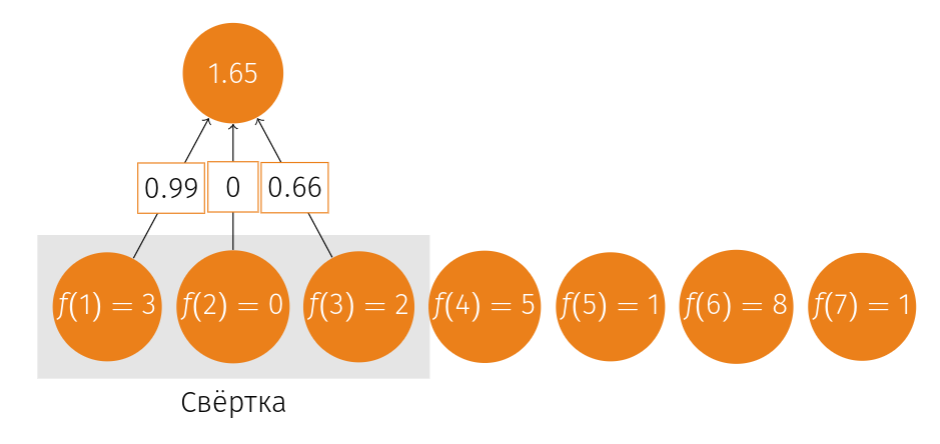

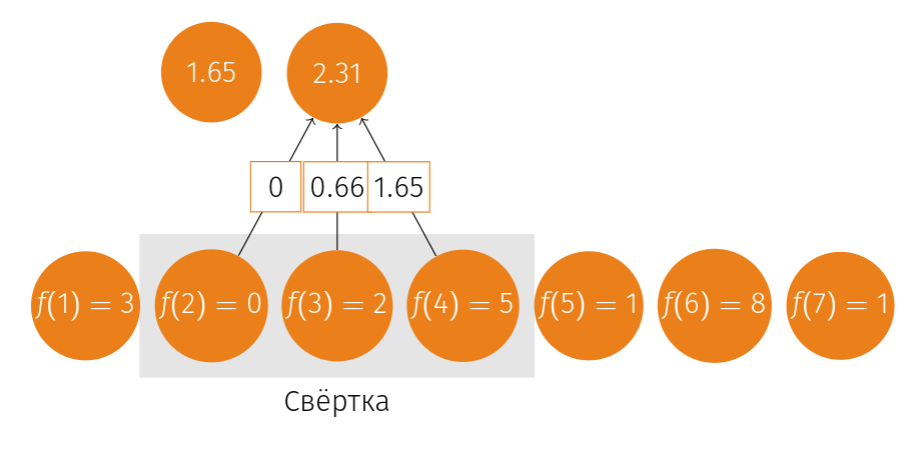

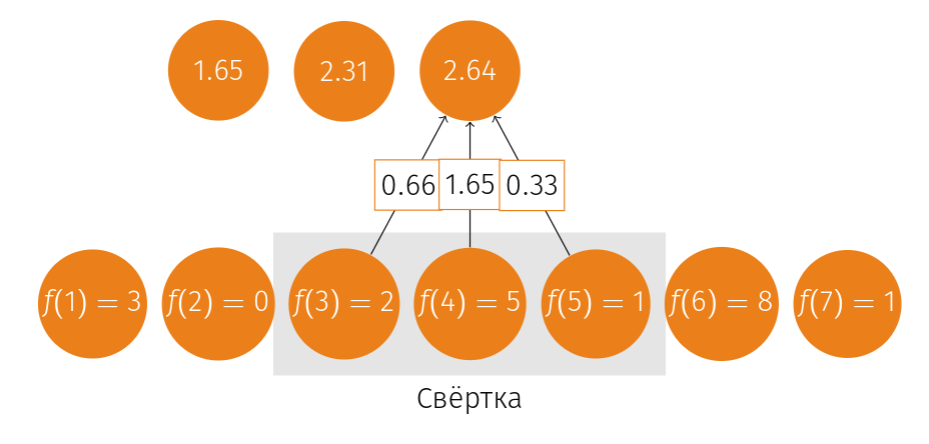

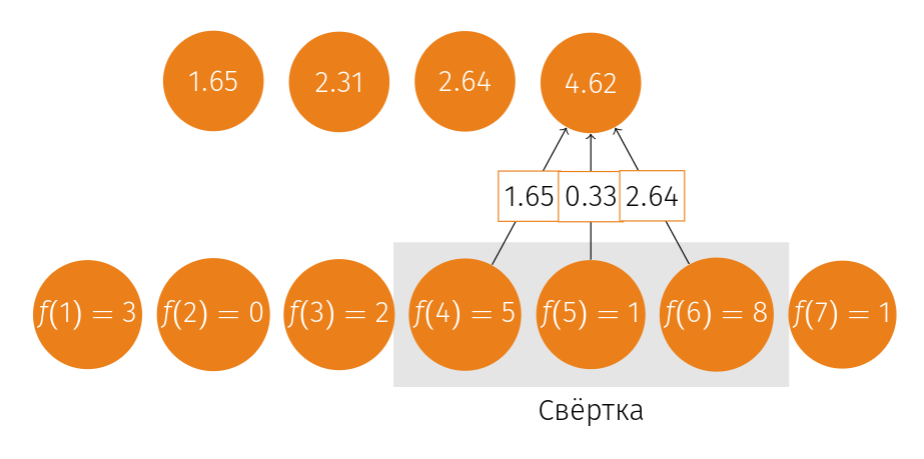

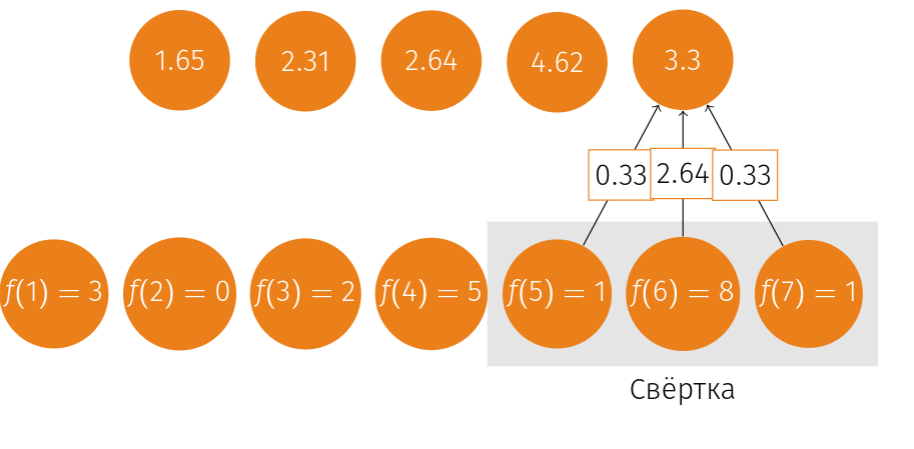

* Ядро в данном случае задаёт обычную линейную комбинацию и полностью определено вектором $(0.33, 0.33, 0.33)$
* Среди значений свёртки не хватает двух элементов. Это вызвано тем, что окно не выходит за пределы имеющегося ряда. Такой тип свёрток обычно называют **valid convolution**
* Так же часто используются **same convolution**. В этом случае "недостающие" элементы заполняются нулями, и результирующий ряд имеет такое же количество элементов.
* В данном примере использовался единичный шаг окна, однако этот параметр может меняться. Шаг обычно обозначается **stride**.

### Реальный пример

* Курс рубля к доллару очень волатилен
* График курса выглядит некрасиво, но нам необходимо вставить его в отчёт для начальства
* График нужно сгладить

Получим актуальный обменный курс из открытого API http://fixer.io/

In [3]:
import requests, time, datetime

In [17]:
response = requests.get('https://api.fixer.io/latest?base=USD&symbols=RUB')

In [83]:
date = datetime.date.today()
exchange_data = []

for _ in range(220):
    response = requests.get(f'https://api.fixer.io/{date}?base=USD&symbols=RUB')
    time.sleep(0.01)
    if response.status_code != 200:
        print(f'Error! {response.status_code}', end='\r')
        time.sleep(10)
        continue
    data = response.json()
    exchange_data.append(data['rates']['RUB'])
    date -= datetime.timedelta(5)
    print(f'{len(exchange_data)} / 220', end='\r')
print(f'Done!')

Done! 2209


In [90]:
# Запишем данные в обратном порядке
exchange_data = np.array(list(reversed(exchange_data)))

In [92]:
#np.savez('dollar', exchange_data)

Визуализируем данные

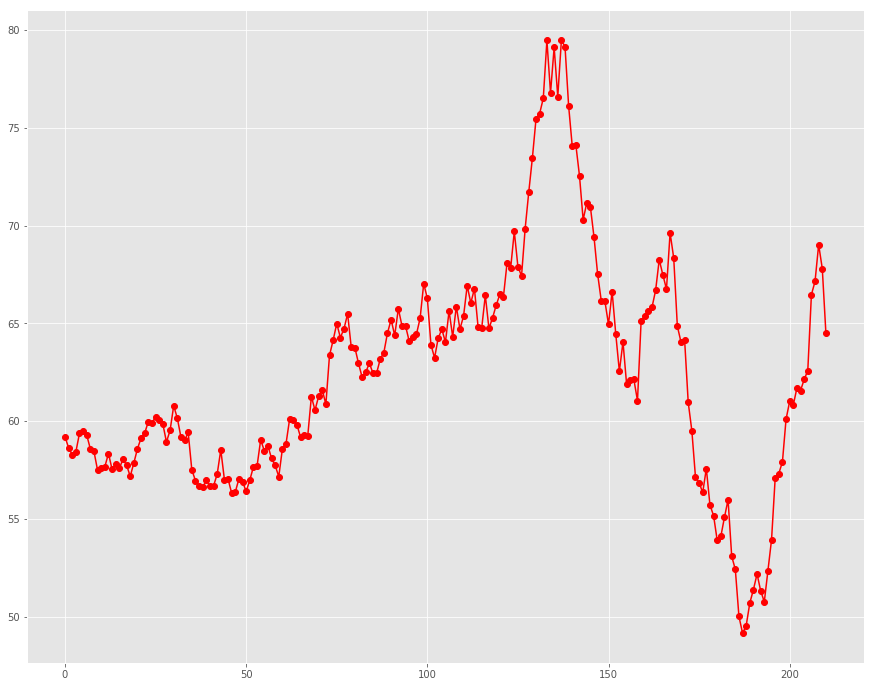

In [91]:
plt.plot(exchange_data, 'r-o')

Теперь реализуем простую функцию свертки

In [95]:
def simple_conv(f, k):
    result = []
    f_len = len(f)
    k_len = len(k)
    
    if f_len <= k_len:
        raise Error('Оригинал меньше ядра!')
    
    for i in range(f_len - k_len):
        w = f[i:i + k_len]
        result.append(np.sum(w * k))
    return result

Применим функцию к данным

In [97]:
smoothed_data = simple_conv(exchange_data, np.array([0.33, 0.33, 0.33]))

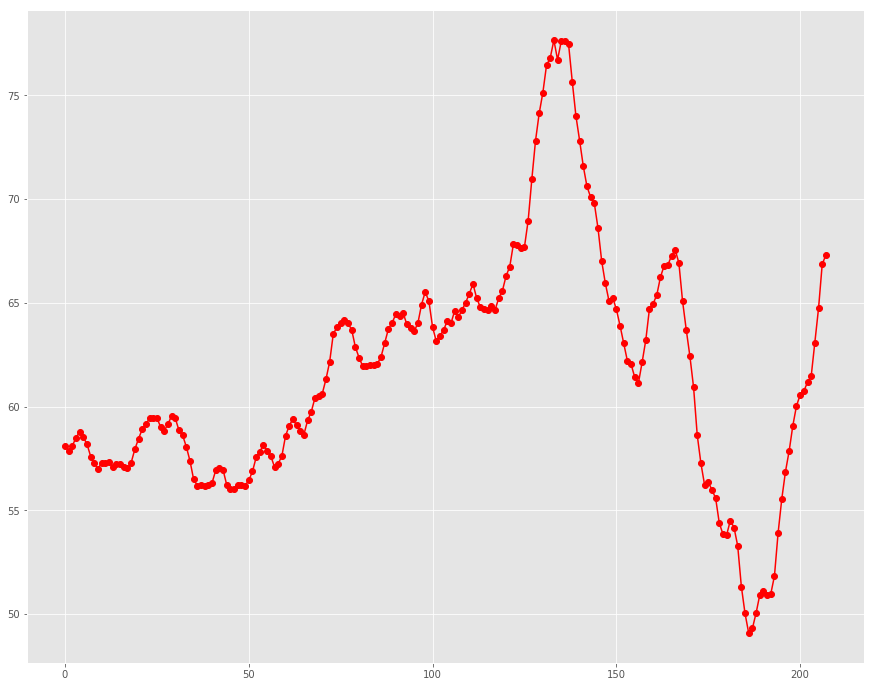

In [98]:
plt.plot(smoothed_data, 'r-o')

Усилим сглаживание

In [102]:
smoothed_data = simple_conv(exchange_data, np.ones(6) / 6)

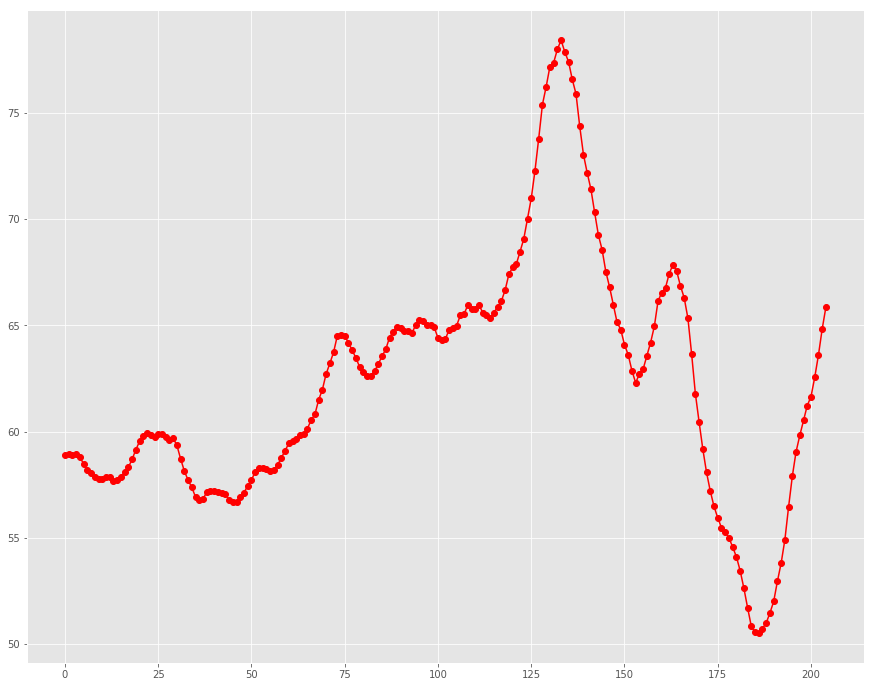

In [103]:
plt.plot(smoothed_data, 'r-o')

### Свёртки для изображений

* Для эффективной работы с изображениями нужна операция, действующая локально



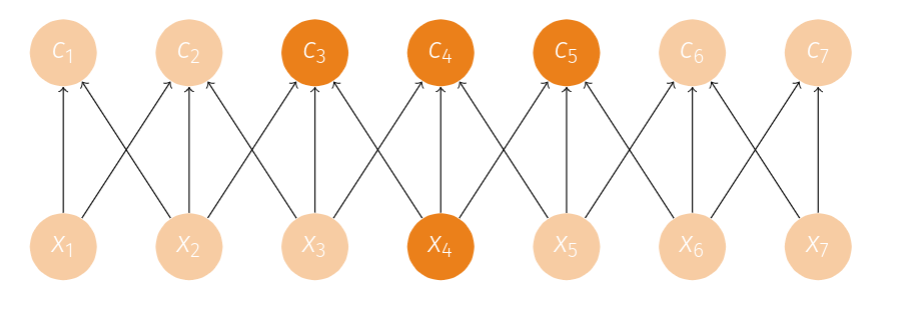

* Каждый вход влияет только на три узла (зависит от размера ядра свёртки)
* Притом веса используются повторно. Например, вес "соединяющий" $x_4$ и $с_5$ равен весу связи $x_6$ и $с_7$. 
* Свёртки действуют *локально*!

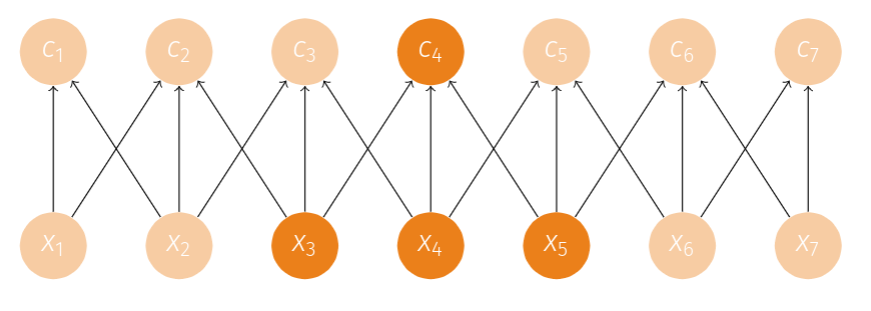

* Каждый узел изменяется под действием только трёх входов (зависит от размера ядра свёртки)
* Входы $x_3, x_4, x_5$ называются **зоной видимости или рецептивным полем** (receptive field) узла $c_4$    
* Зона видимости зависит от глубины

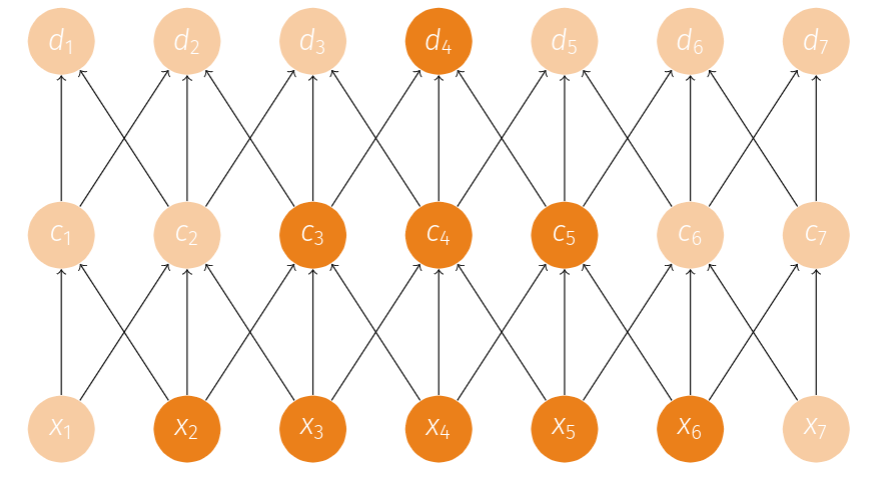

Зона видимости так же зависит от размера шага. Чем больше шаг,тем больше зона:
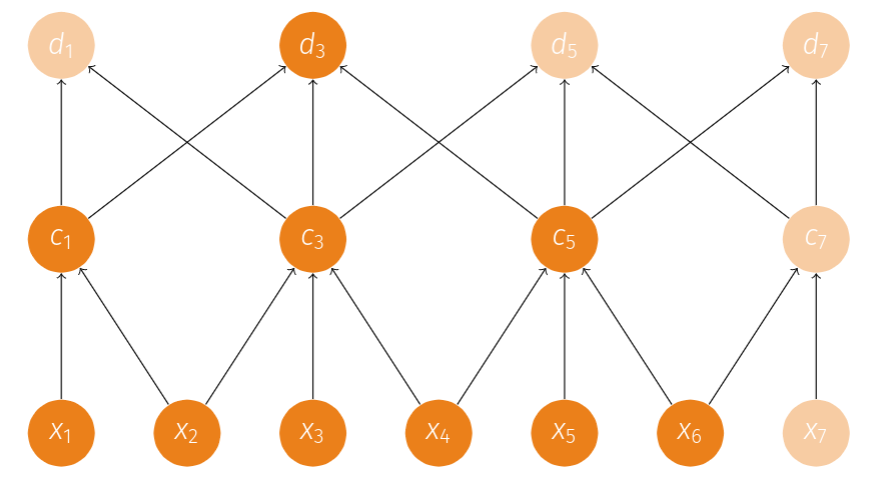

Свёртки легко обобщаются на двухмерный(n-мерный) случай:
	$$ (f \ast K)(x, y)  = \sum\limits_{\tau, \eta} f(\tau, \eta) K(x -\tau, y - \eta) =  \sum\limits_{\tau, \eta} f(x -\tau, y - \eta) K (\tau, \eta) $$

Иллюстрации из https://github.com/vdumoulin/conv_arithmetic

<table style="width:100%">
  <tr>
    <td><img src="gif/no_padding_no_strides.gif"></td>
    <td><img src="gif/arbitrary_padding_no_strides.gif"></td>
    <td><img src="gif/same_padding_no_strides.gif"></td>
    <td><img src="gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img src="gif/no_padding_no_strides_transposed.gif"></td>
    <td><img src="gif/arbitrary_padding_no_strides_transposed.gif"></td>
    <td><img src="gif/same_padding_no_strides_transposed.gif"></td>
    <td><img src="gif/full_padding_no_strides_transposed.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides, transposed</td>
    <td>Arbitrary padding, no strides, transposed</td>
    <td>Half padding, no strides, transposed</td>
    <td>Full padding, no strides, transposed</td>
  </tr>
  <tr>
    <td><img src="gif/no_padding_strides.gif"></td>
    <td><img src="gif/padding_strides.gif"></td>
    <td><img src="gif/padding_strides_odd.gif"></td>
    <td><img src="gif/dilation.gif"></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td>No padding, no stride, dilation</td>
  </tr>
  <tr>
    <td><img src="gif/no_padding_strides_transposed.gif"></td>
    <td><img src="gif/padding_strides_transposed.gif"></td>
    <td><img src="gif/padding_strides_odd_transposed.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides, transposed</td>
    <td>Padding, strides, transposed</td>
    <td>Padding, strides, transposed (odd)</td>
    <td></td>
  </tr>
</table>

###   Применим свёртку к изображению

In [118]:
from imageio import imread

In [159]:
image = imread('owl.jpg')

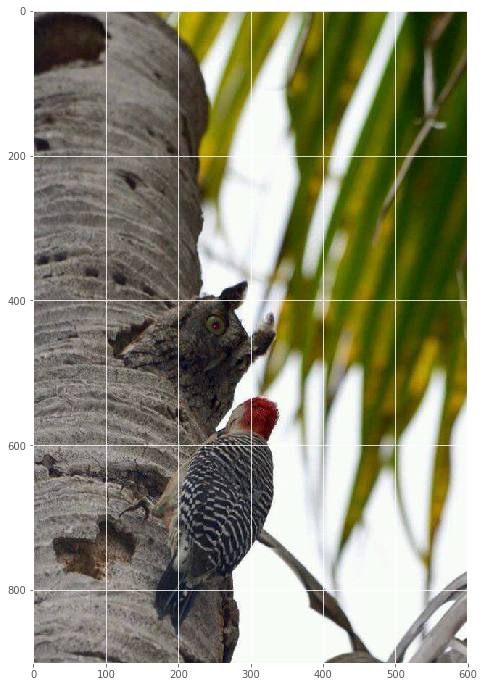

In [160]:
plt.imshow(image)

In [161]:
def conv2d(input_image, kernel):
    h, w, d = input_image.shape
    k_h, k_w = kernel.shape
    
    result_h = h - k_h + 1
    result_w = w - k_w + 1
    
    result = np.zeros((result_h, result_w, d))
    
    for i in range (0, result_h - 1):
        for j in range (0, result_w - 1):
            
            h_start  = i
            h_stop = h_start + k_h

            w_start  = j
            w_stop = w_start + k_w
            
            window = input_image[h_start:h_stop, w_start:w_stop, :]
            bb, nn, dd = window.shape

            
            window = np.transpose(window, axes=(2,0,1))
            temp = np.sum(np.multiply(window, kernel), axis=(1,2))
            result[i,j] = temp
            
    return result.astype(np.uint8)


In [162]:
kernel_1 = np.array([[1,1,1], [1,1,1], [1,1,1]]) / 9

In [163]:
blured = conv2d(image, kernel_1)

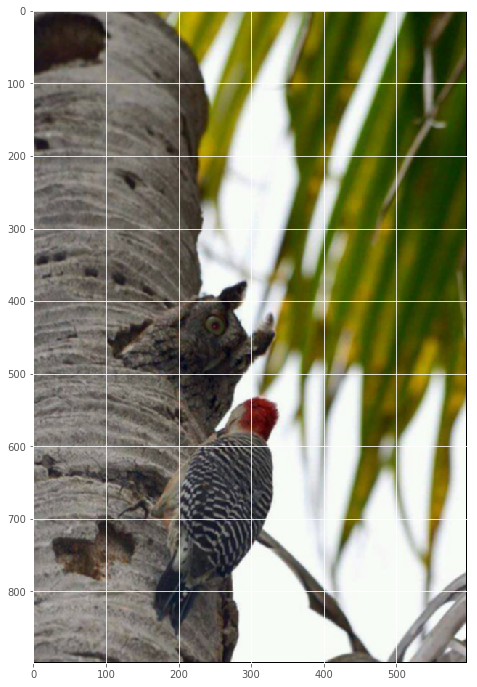

In [164]:
plt.imshow(blured)

In [165]:
kernel_2 = np.ones((10,10)) / 100

In [166]:
blured = conv2d(image, kernel_2)

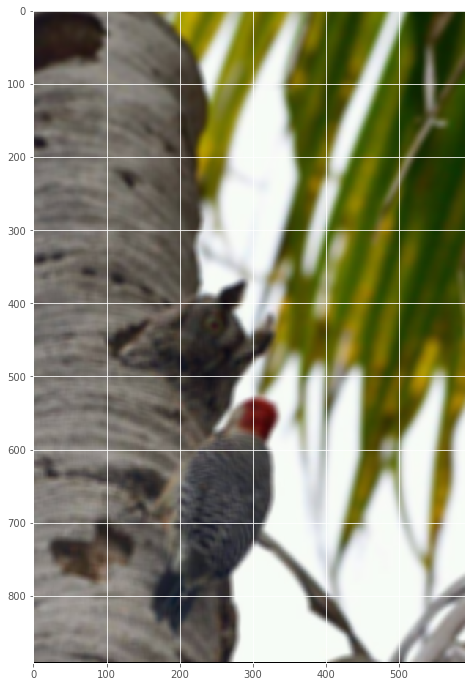

In [167]:
plt.imshow(blured)

In [172]:
kernel_3 = np.array([[0,1,0], [1,-4,1], [0,1,0]]) 

In [173]:
edges = conv2d(image, kernel_3)

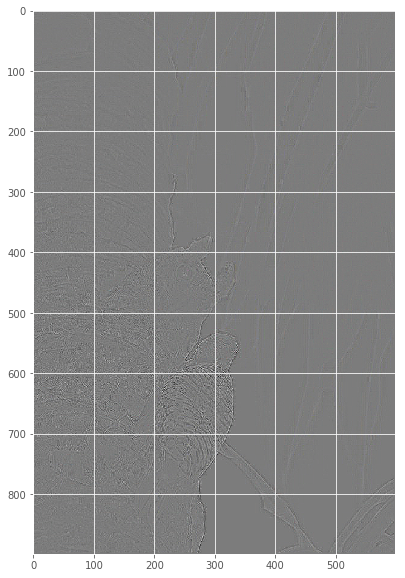